<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-09 00:02:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-07-09 00:02:00 (14.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



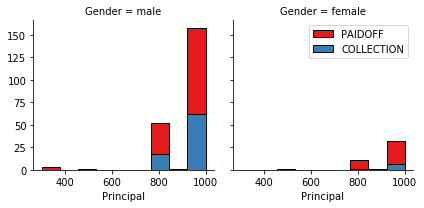

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

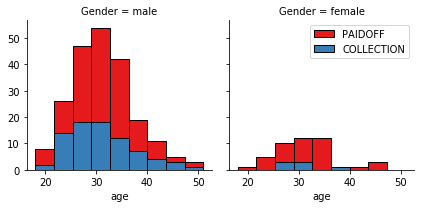

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

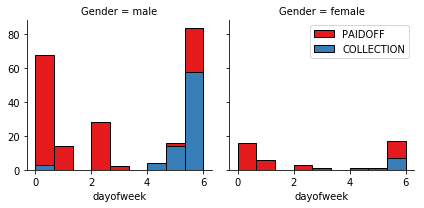

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

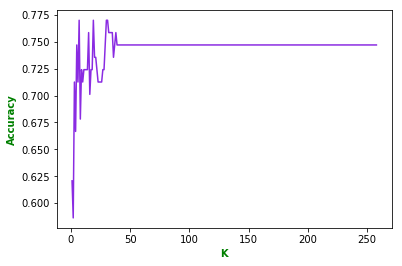

Max accuracy of 77.0 % occurs when K =  7
Best KNN model is KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#calculate errors for various choices of K
Ks = len(X_train)
mean_acc = np.zeros((Ks-1))

for n in range(1, Ks):
    #train model and predict y_hat
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    y_hat = neigh.predict(X_test)
    #compute accuracy for this K, recall accuracy_score is correct category matches
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_hat)

#visualize results of different Ks
plt.plot(range(1, Ks), mean_acc, c='blueviolet')
plt.ylabel('Accuracy', color='green', fontweight='bold')
plt.xlabel('K', color='green', fontweight='bold')
plt.show()

# save K with best accuracy_score (Jaccard Index) in variable named best_K for use later
best_K = np.argmax(mean_acc)+1
print("Max accuracy of", round(mean_acc.max(), 2)*100, "% occurs when K = ", best_K)

# define best KNN model
neigh_best = KNeighborsClassifier(n_neighbors = best_K).fit(X_train, y_train)
print("Best KNN model is", neigh_best)


#### *JSW notes on KNN model* ####
*best_k is sensitive to intial conditions.  E.g. train_test_split random_state =1 gives a very different 
best_k than if random_state is seeded with 2 or 3 or 4. Therefore, we should have low confidence that neigh_best is significantly better than other choices. 
Next step should be to use K-Fold method in order to make better use of the existing data when evaluating different KNNs*


# Decision Tree

In [22]:
# import libraries
from sklearn.tree import DecisionTreeClassifier

In [23]:
# Define inputs
X2 = Feature
y2 = y
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=1)

In [24]:
# Fit model
loan_tree = DecisionTreeClassifier(criterion='entropy')
loan_tree.fit(X2_train, y2_train)

# Test model
pred_tree = loan_tree.predict(X2_test)
print("Tree model accuracy is ", metrics.accuracy_score(y2_test, pred_tree))

Tree model accuracy is  0.6551724137931034


In [25]:
# Compare two choices for class_weight to see if it influences accuracy

loan_tree_balance = DecisionTreeClassifier(criterion='entropy', class_weight="balanced")
loan_tree_balance.fit(X2_train, y2_train)
pred_tree_balance = loan_tree_balance.predict(X2_test)

a = metrics.accuracy_score(y2_test, pred_tree)
a_b = metrics.accuracy_score(y2_test, pred_tree_balance)

print("Normal tree model accuracy with respect to test set is", round(a, 3)*100, "%")
print("Balanced tree model accuracy with respect to test set is", round(a_b,3)*100, "%")
print("On this basis, prefer", "Normal" if a>=a_b else "Balanced" )
print("")
print("Best model is", loan_tree if a>=a_b else loan_tree_balanced)


Normal tree model accuracy with respect to test set is 65.5 %
Balanced tree model accuracy with respect to test set is 64.4 %
On this basis, prefer Normal

Best model is DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


# Support Vector Machine

For linear kernel
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        22
     PAIDOFF       0.75      1.00      0.86        65

   micro avg       0.75      0.75      0.75        87
   macro avg       0.37      0.50      0.43        87
weighted avg       0.56      0.75      0.64        87

For poly kernel
              precision    recall  f1-score   support

  COLLECTION       0.50      0.09      0.15        22
     PAIDOFF       0.76      0.97      0.85        65

   micro avg       0.75      0.75      0.75        87
   macro avg       0.63      0.53      0.50        87
weighted avg       0.69      0.75      0.67        87

For rbf kernel
              precision    recall  f1-score   support

  COLLECTION       0.67      0.09      0.16        22
     PAIDOFF       0.76      0.98      0.86        65

   micro avg       0.76      0.76      0.76        87
   macro avg       0.71      0.54      0.51        87
weighted avg       0.74  

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classificatio

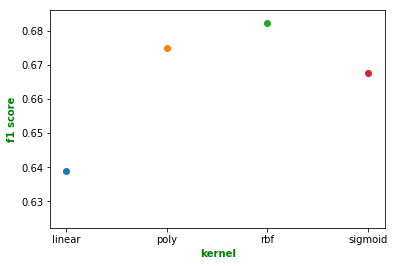

The best kernel to use is rbf


In [26]:
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# define inputs
X3 = Feature
y3 = y

# normalize inputs
X3 = preprocessing.StandardScaler().fit(X3).transform(X3)

# split into training and testing subsets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=1)

#create dictionary for results of testing kernels
results = {}

#which kernel produces best accuracy
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernel:
    clf = svm.SVC(kernel=kernel)
    clf.fit(X3_train, y3_train)
    y3_hat = clf.predict(X3_test)
    
    #calc f1 score for each kernel
    f1_kernel = f1_score(y3_test, y3_hat, average='weighted')

    #output details of each kernel's f1 score
    print("For {} kernel".format(kernel))
    print(classification_report(y3_test, y3_hat))
    
    results[kernel] = f1_kernel
    
#summarize results
for key in results:
    plt.scatter([key], results[key], label=key)
plt.xlabel('kernel', color='green', fontweight='bold')
plt.ylabel('f1 score', color='green', fontweight='bold')
plt.show()
keymax=max(results, key=results.get)
print("The best kernel to use is",keymax)

In [27]:
# create best model using result above
clf_best = svm.SVC(kernel=keymax)
clf_best.fit(X3_train, y3_train)
clf_best

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Logistic Regression

In [28]:
import scipy.optimize as opt


# define inputs
X4 = Feature
y4 = y

# normalize
X4 = preprocessing.StandardScaler().fit(X4).transform(X4)

# split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.25, random_state=2)



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X4_train, y4_train)

y4_hat = LR.predict(X4_test)
y4_hat_prob = LR.predict_proba(X4_test)

a = jaccard_similarity_score(y4_test, y4_hat)
a

0.7701149425287356

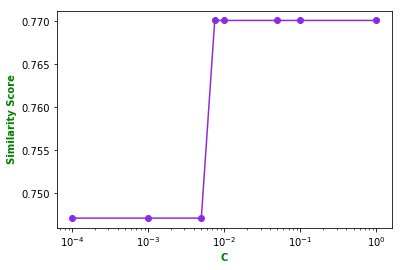

In [30]:
# Test different values for C to see if it improves the model

C_test= [0.0001, 0.001, 0.005, 0.0075, 0.01, 0.05, 0.1, 1.0]
jss = np.zeros((len(C_test)))

j=0
for i in C_test:
    LR_test = LogisticRegression(C=i, solver='liblinear').fit(X4_train, y4_train)
    y4_hat_test = LR_test.predict(X4_test)
    jss[j] = jaccard_similarity_score(y4_test, y4_hat_test)
    j=j+1

#visualize results of different Ks
plt.plot(C_test, jss, c='blueviolet', marker = 'o')
plt.ylabel('Similarity Score', color='green', fontweight='bold')
plt.xlabel('C', color='green', fontweight='bold')
plt.xscale('log')
plt.show()


In [31]:
# looks like as long as C is greater than approx 0.0075, accuracy is good
LR_best = LogisticRegression(C=0.01, solver='liblinear').fit(X4_train, y4_train)

# Model Evaluation using Test set

In [32]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [33]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-09 00:03:52--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-09 00:03:53 (203 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
#scrub data
#change date column to dates
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#drop columns not used 
test_df.drop(columns=['due_date'], inplace=True)
test_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

#assign 0 1 to gender
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#One hot encode education
test_df = pd.concat([test_df,pd.get_dummies(test_df['education'])], axis=1)

# remove additional unused features
test_df.drop(columns=["education"], inplace=True)
test_df.drop(columns=["Master or Above"], inplace=True)

# create weekend code and apply to effective_date
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [37]:
# identify columns to use

test_Features = test_df[['Principal','terms','age','Gender','weekend', 'Bechalor', 'High School or Below', 'college']]

In [38]:
# define features and target
X5 = test_Features
y5 = test_df['loan_status']

# normalize features
X5 = preprocessing.StandardScaler().fit(X5).transform(X5)

# As a note: I will not refit the model on the test data set so I don't need train_test_split

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [39]:
# KNN
y_hat_KNN = neigh_best.predict(X5)
KNN_jss = jaccard_similarity_score(y5, y_hat_KNN)
KNN_f1 = f1_score(y5, y_hat_KNN, average='weighted')


# Decision Tree
y_hat_DT = loan_tree.predict(X5)
DT_jss = jaccard_similarity_score(y5, y_hat_DT)
DT_f1= f1_score(y5, y_hat_DT, average='weighted')

# SVM
y_hat_SVM = clf_best.predict(X5)
SVM_jss = jaccard_similarity_score(y5, y_hat_SVM)
SVM_f1= f1_score(y5, y_hat_SVM, average='weighted')

# Logistic Regression
y_hat_LR = LR_best.predict(X5)
LR_jss = jaccard_similarity_score(y5, y_hat_LR)
LR_f1 = f1_score(y5, y_hat_LR, average='weighted')

#encode results as float for log_loss calcs
y5_LL = []
y_hat_LR_LL = []
for i in range(y5.shape[0]):
    a = 1.0 if y5[i] == "PAIDOFF" else 0.0
    y5_LL.append(a)
    b = 1.0 if y_hat_LR[i] =="PAIDOFF" else 0.0
    y_hat_LR_LL.append(b)
LR_LL = log_loss(y5_LL, y_hat_LR_LL)


# organize output
report_list = [['KNN', KNN_jss, KNN_f1, ""],['DT', DT_jss, DT_f1, ""],['SVM', SVM_jss, SVM_f1, ""],['LR', LR_jss, LR_f1, LR_LL]]
report = pd.DataFrame(report_list, columns=['Algorithm', 'Jaccard', 'F1-score', "LogLoss"])
report

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.629630,0.619901,
1,DT,0.740741,0.630418,
2,SVM,0.722222,0.621266,
3,LR,0.740741,0.660427,8.95469


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>